In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import pickle
import seaborn as sns
import math
from scipy.stats import pearsonr, spearmanr, multivariate_normal as norm
from scipy.spatial import Voronoi, KDTree
from itertools import product

from matplotlib import pyplot as plt
from matplotlib import patches
PATH = '../data/' 

%matplotlib inline

# Functions

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [3]:
def get_dx_dy(radian_angle, dist):
    dx = dist * np.cos(radian_angle)
    dy = dist * np.sin(radian_angle)
    return dx, dy

In [4]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12*2, 6.33*2)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0,  alpha=0.5)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

In [5]:
def show_pitch_control(play_id, df, no_offense=False, no_rusher=False):
    df_play = df[df.PlayId == play_id]
    pc = get_pitch_control(df_play, no_offense=no_offense, no_rusher=no_rusher)
    YardLine = df_play.YardLine_std.values[0]
    
    ## field
    fig, ax = create_football_field(highlight_line=True,
                                    highlight_line_number=YardLine)
    
    ## pitch control contourf
    x, y = np.mgrid[0 : 120 : 0.5, 0 : 54 : 0.5]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0], pos[:, :, 1] = x, y
    ax.contourf(x, y, pc(pos), cmap='summer', alpha=0.9)
    
    ## players and their speeds
    ax.scatter(df_play.X_std, df_play.Y_std, cmap='rainbow', c=~df_play.IsOnOffense, s=100)
    rusher_row = df_play[df_play.IsBallCarrier]
    ax.scatter(rusher_row.X_std, rusher_row.Y_std, color='black', s=100)
    yards_covered = rusher_row["Yards"].values[0]

    for (x, y, angle, S) in zip(df_play.X_std, df_play.Y_std, df_play.Dir_std, df_play.S):       
        dx, dy = get_dx_dy(angle, S)
        ax.arrow(x, y, dx, dy, length_includes_head=False, width=0.2, color='black', alpha=0.5)
    plt.title(f'Play # {play_id}, yard distance is {yards_covered}, scrimage is {YardLine} ', fontsize=20)
    plt.show()
    

# Parse data

In [93]:
df = pd.read_csv(PATH + 'train_preprocessed.csv', low_memory=False)
df['A_corr'] = df.A
df_play = df[df.IsBallCarrier].reset_index(drop=True)
df.head()

,PlayId,S,A,Season,Down,Distance,DefendersInTheBox,Yards,Position,Week,Turf,IsBallCarrier,IsOnOffense,YardLine_std,X_std,Y_std,Dir_std,Orientation_std,A_corr
0,20170907000118,1.918005,1.227944,2017,3,2,6.0,8,SS,1,0,False,False,35,46.09,18.493333,1.620015,4.572588,1.227944
1,20170907000118,0.488716,1.493167,2017,3,2,6.0,8,DE,1,0,False,False,35,45.33,20.693333,1.244420,3.623478,1.493167
2,20170907000118,1.389056,0.576939,2017,3,2,6.0,8,DE,1,0,False,False,35,46.00,20.133333,1.174083,3.194127,0.576939
3,20170907000118,0.488716,0.516661,2017,3,2,6.0,8,ILB,1,0,False,False,35,48.54,25.633333,2.868623,3.137578,0.516661
4,20170907000118,2.064311,2.795176,2017,3,2,6.0,8,FS,1,0,False,False,35,50.68,17.913333,1.844638,3.362028,2.795176


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509762 entries, 0 to 509761
Data columns (total 18 columns):
PlayId               509762 non-null int64
S                    509762 non-null float64
A                    509762 non-null float64
Season               509762 non-null int64
Down                 509762 non-null int64
Distance             509762 non-null int64
DefendersInTheBox    509762 non-null float64
Yards                509762 non-null int64
Position             509762 non-null object
Week                 509762 non-null int64
Turf                 509762 non-null int64
IsBallCarrier        509762 non-null bool
IsOnOffense          509762 non-null bool
YardLine_std         509762 non-null int64
X_std                509762 non-null float64
Y_std                509762 non-null float64
Dir_std              509762 non-null float64
Orientation_std      509762 non-null float64
dtypes: bool(2), float64(7), int64(8), object(1)
memory usage: 63.2+ MB


In [8]:
df.describe()

,PlayId,S,A,Season,Down,Distance,DefendersInTheBox,Yards,Week,Turf,YardLine_std,X_std,Y_std,Dir_std,Orientation_std
count,5.097620e+05,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000
mean,2.017594e+13,2.757032,1.781995,2017.486427,1.520651,8.329248,6.943032,4.212334,9.096370,0.553753,47.961849,58.900604,26.803957,3.090118,3.165497
std,4.997098e+09,1.455131,1.060305,0.499816,0.674987,3.795208,0.991066,6.436167,5.000984,0.497103,25.160334,25.411522,7.237847,1.872693,1.853815
min,2.017091e+13,0.000000,-0.134343,2017.000000,1.000000,1.000000,1.000000,-14.000000,1.000000,0.000000,1.000000,3.160000,2.690000,0.000000,0.000000
25%,2.017111e+13,1.602886,0.962720,2017.000000,1.000000,6.000000,6.000000,1.000000,5.000000,0.000000,26.000000,37.850000,22.683333,1.432217,1.944471
50%,2.017123e+13,2.627023,1.625779,2017.000000,1.000000,10.000000,7.000000,3.000000,9.000000,1.000000,44.000000,55.010000,26.750000,3.001792,3.156777
75%,2.018110e+13,3.797465,2.457618,2018.000000,2.000000,10.000000,8.000000,6.000000,14.000000,1.000000,68.000000,78.770000,30.830000,4.781679,4.453382
max,2.018123e+13,10.156116,14.710000,2018.000000,4.000000,40.000000,11.000000,99.000000,17.000000,1.000000,99.000000,119.340000,56.450000,6.283011,6.283011


# Single feature analysis

### YardLine

In [295]:
spearmanr(df_play[df_play.Season == 2017].Yards, df_play[df_play.Season == 2017].YardLine_std)

SpearmanrResult(correlation=-0.08798694072932264, pvalue=6.851626878757916e-22)

In [296]:
spearmanr(df_play[df_play.Season == 2018].Yards, df_play[df_play.Season == 2018].YardLine_std)

SpearmanrResult(correlation=-0.09888238288590136, pvalue=6.806117000346859e-26)

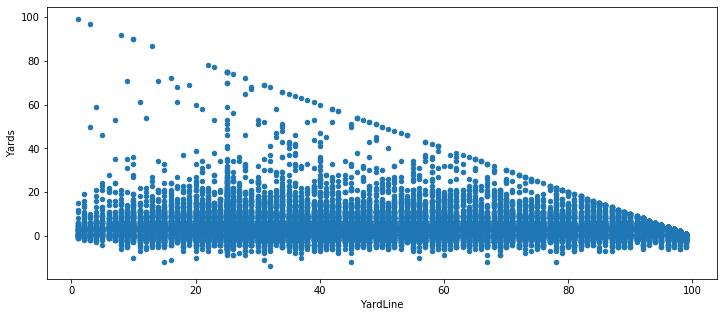

In [110]:
plt.figure(figsize=(12, 5))
plt.scatter(df_play.YardLine_std, df_play.Yards, s=20)
plt.xlabel("YardLine")
plt.ylabel("Yards")

plt.show()

### Speed

In [9]:
spearmanr(df_play[df_play.Season == 2017].Yards, df_play[df_play.Season == 2017].S)

SpearmanrResult(correlation=0.13456618382337, pvalue=3.3130565595273724e-49)

In [10]:
spearmanr(df_play[df_play.Season == 2018].Yards, df_play[df_play.Season == 2018].S)

SpearmanrResult(correlation=0.04634545300761588, pvalue=8.55055956161226e-07)

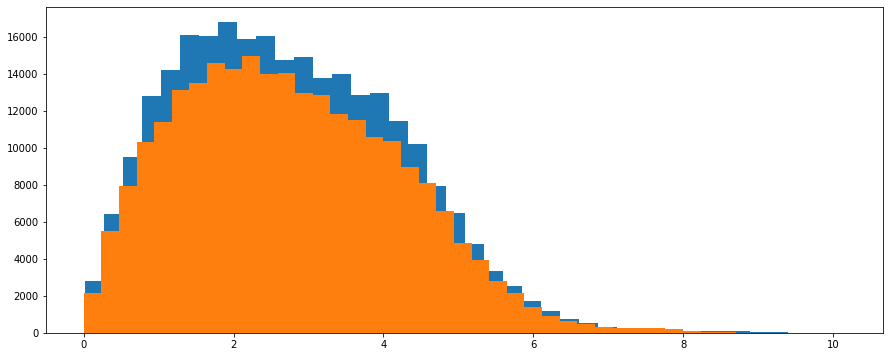

In [11]:
plt.figure(figsize=(15, 6))
plt.hist(df[df.Season == 2017].S, bins=40)
plt.hist(df[df.Season == 2018].S, bins=40)

plt.show()

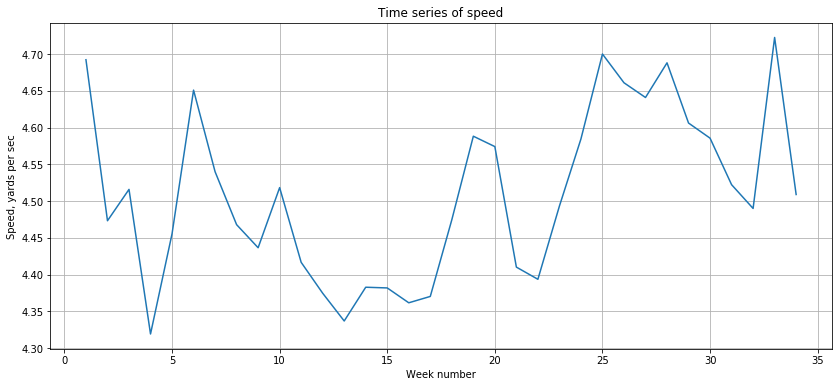

In [12]:
plt.figure(figsize=(14, 6))
df_play['week_number'] = (df_play.Season - 2017)* 17 + df_play.Week
g = df_play.groupby('week_number').S.mean()
plt.plot(df_play.week_number, df_play.week_number.map(g))
plt.title('Time series of speed')
plt.xlabel('Week number')
plt.ylabel('Speed, yards per sec')


plt.grid()
plt.show()

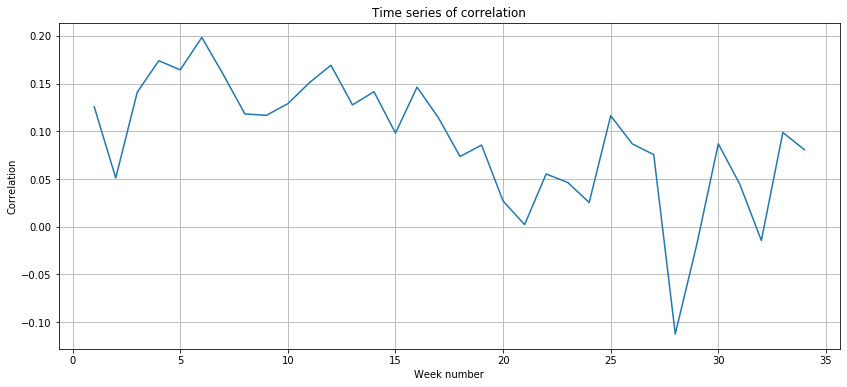

In [13]:
plt.figure(figsize=(14, 6))
g = df_play.groupby('week_number').apply(lambda play: spearmanr(play.S, play.Yards)[0])
plt.plot(df_play.week_number, df_play.week_number.map(g))
plt.title('Time series of correlation')
plt.xlabel('Week number')
plt.ylabel('Correlation')


plt.grid()
plt.show()

### Acceleration

In [94]:
spearmanr(df_play[df_play.Season == 2017].Yards, df_play[df_play.Season == 2017].A_corr)

SpearmanrResult(correlation=0.3861939610292453, pvalue=0.0)

In [95]:
spearmanr(df_play[df_play.Season == 2018].Yards, df_play[df_play.Season == 2018].A_corr)

SpearmanrResult(correlation=0.09271622039806439, pvalue=5.999903238355544e-23)

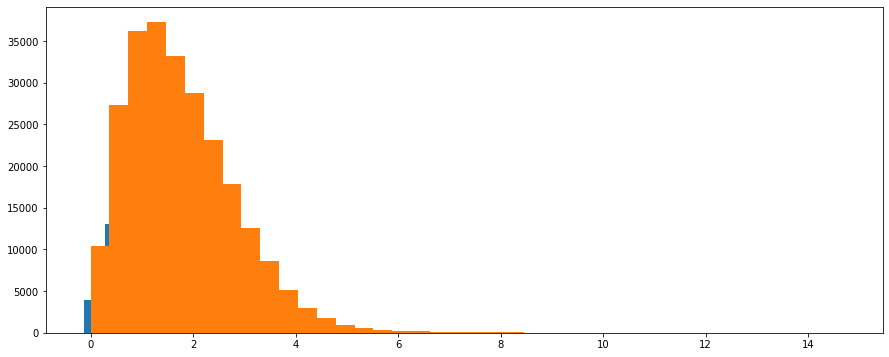

In [58]:
plt.figure(figsize=(15, 6))
plt.hist(df[df.Season == 2017].A, bins=40)
plt.hist(df[df.Season == 2018].A, bins=40)

plt.show()

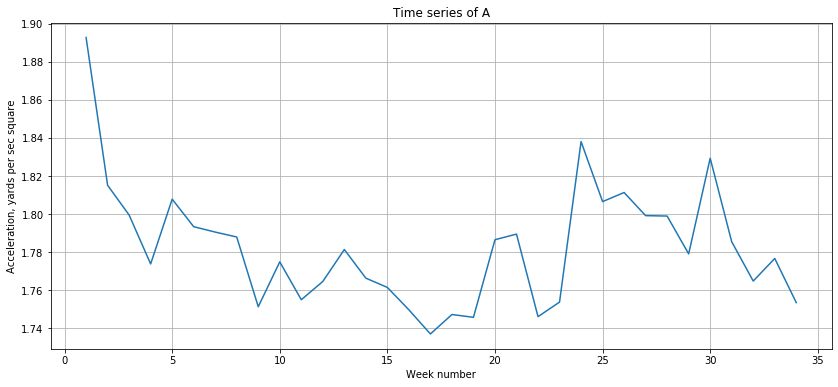

In [92]:
plt.figure(figsize=(14, 6))
df['week_number'] = (df.Season - 2017)* 17 + df.Week
g = df.groupby('week_number').A.mean()
plt.plot(df.week_number, df.week_number.map(g))
plt.title('Time series of A')
plt.xlabel('Week number')
plt.ylabel('Acceleration, yards per sec square')


plt.grid()
plt.show()

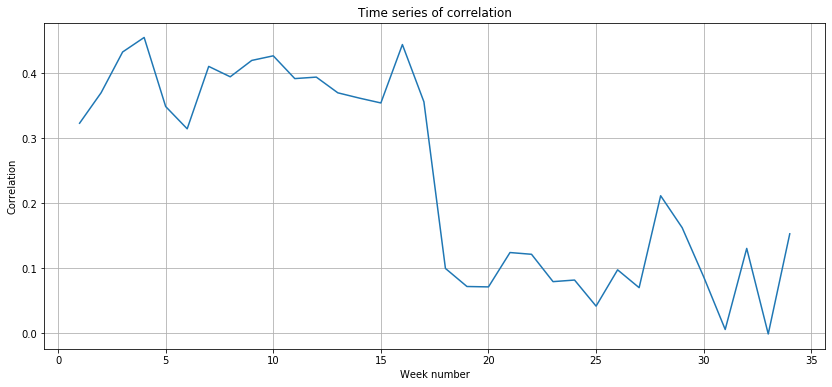

In [18]:
plt.figure(figsize=(14, 6))
g = df_play.groupby('week_number').apply(lambda play: spearmanr(play.A, play.Yards)[0])
plt.plot(df_play.week_number, df_play.week_number.map(g))
plt.title('Time series of correlation')
plt.xlabel('Week number')
plt.ylabel('Correlation')


plt.grid()
plt.show()

SpearmanrResult(correlation=0.35444988590072574, pvalue=0.0)


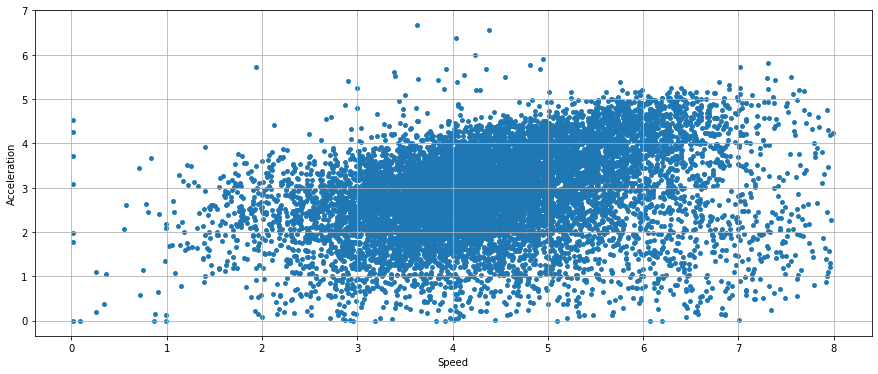

In [53]:
df_play_17 = df_play[df_play.Season == 2017]
S_0 = 8
print(spearmanr(df_play_17[df_play_17.S < S_0].S, df_play_17[df_play_17.S < S_0].A.clip(0, 7)))
plt.figure(figsize=(15, 6))
plt.scatter(df_play_17[df_play_17.S < S_0].S, df_play_17[df_play_17.S < S_0].A.clip(0, 7), s=15)
plt.xlabel('Speed')
plt.ylabel('Acceleration')

plt.grid()
plt.show()

SpearmanrResult(correlation=0.15844883598262807, pvalue=4.5127810162881774e-64)


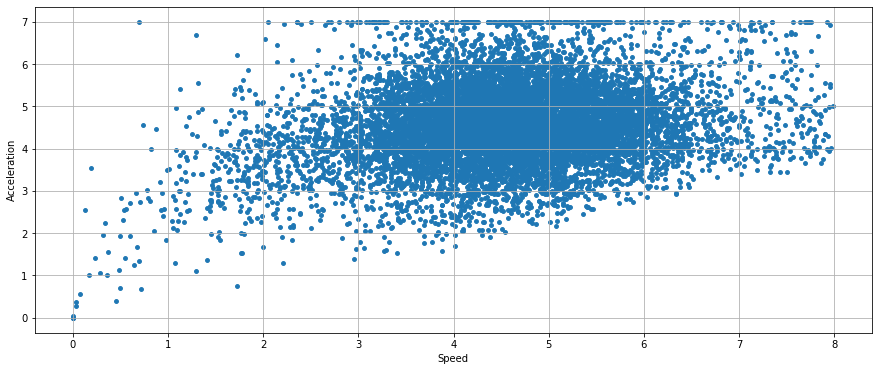

In [104]:
df_play_18 = df_play[df_play.Season == 2018].reset_index(drop=True)
S_0 = 8
df_play_18['A_corr'] = df_play_18.A + 0.3 * (df_play_18.S ** 1.2) 
print(spearmanr(df_play_18[df_play_18.S < S_0].S, df_play_18[df_play_18.S < S_0].A_corr.clip(0, 7)))
plt.figure(figsize=(15, 6))
plt.scatter(df_play_18[df_play_18.S < S_0].S, df_play_18[df_play_18.S < S_0].A_corr.clip(0, 7), s=15)
plt.xlabel('Speed')
plt.ylabel('Acceleration')

plt.grid()
plt.show()

### Dir and orientation

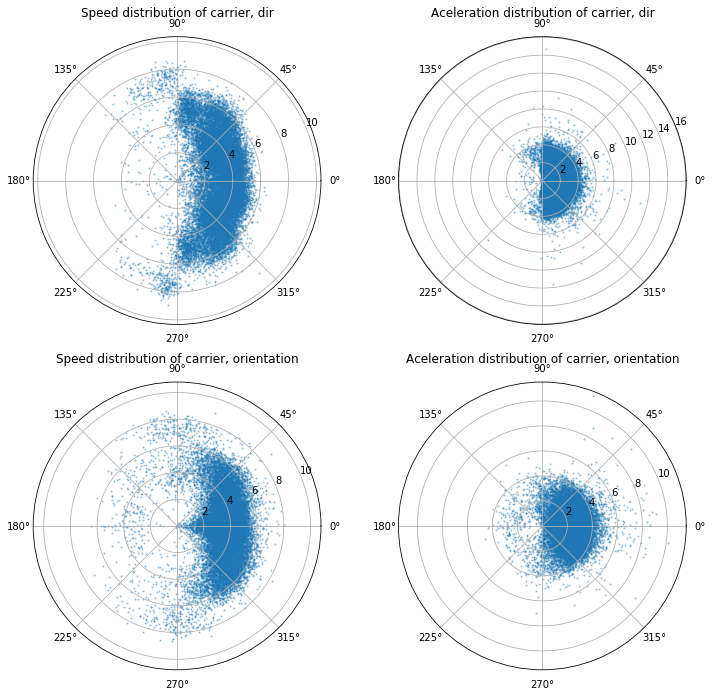

In [537]:
plt.figure(figsize=(12, 18))

ax = plt.subplot(321, projection='polar')
ax.scatter(df_play.Dir_std, df_play.S, s=1.5, alpha=0.3)
ax.set_title('Speed distribution of carrier, dir')

ax = plt.subplot(322, projection='polar')
ax.scatter(df_play.Dir_std, df_play.A, s=1.5, alpha=0.3)
ax.set_title('Aceleration distribution of carrier, dir')

ax = plt.subplot(323, projection='polar')
ax.scatter(df_play.Orientation_std, df_play.S, s=1.5, alpha=0.3)
ax.set_title('Speed distribution of carrier, orientation')

ax = plt.subplot(324, projection='polar')
ax.scatter(df_play.Orientation_std, df_play.A, s=1.5, alpha=0.3)
ax.set_title('Aceleration distribution of carrier, orientation')

plt.show()

### Distance

In [696]:
spearmanr(df_play.Yards, df_play.Distance)

SpearmanrResult(correlation=0.11080084360765702, pvalue=3.35285703892563e-64)

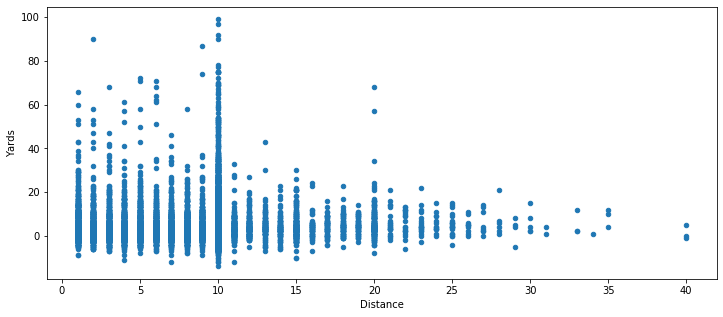

In [699]:
plt.figure(figsize=(12, 5))
plt.scatter(df_play.Distance, df_play.Yards, s=20)
plt.xlabel("Distance")
plt.ylabel("Yards")

plt.show()

### Defenders in the box

In [32]:
spearmanr(df_play[df_play.Season == 2017].Yards, df_play[df_play.Season == 2017].DefendersInTheBox)

SpearmanrResult(correlation=-0.15986501277911294, pvalue=5.910083556338864e-69)

In [33]:
spearmanr(df_play[df_play.Season == 2018].Yards, df_play[df_play.Season == 2018].DefendersInTheBox)

SpearmanrResult(correlation=-0.15404143364582534, pvalue=8.350805174043758e-61)

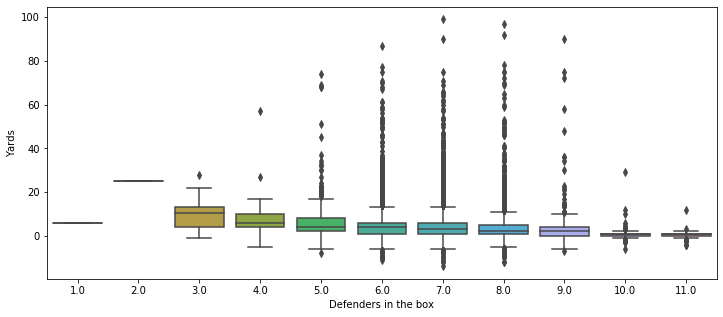

In [545]:
plt.figure(figsize=(12, 5))
sns.boxplot(x=df_play.DefendersInTheBox, y=df_play.Yards)
plt.xlabel("Defenders in the box")
plt.ylabel("Yards")

plt.show()

### Speed_x

In [650]:
df_play['speed_x'] = np.cos(df_play.Dir_std) * df_play.S

In [651]:
spearmanr(df_play.Yards, df_play.speed_x)

SpearmanrResult(correlation=0.0941626627383195, pvalue=8.6286604195306e-47)

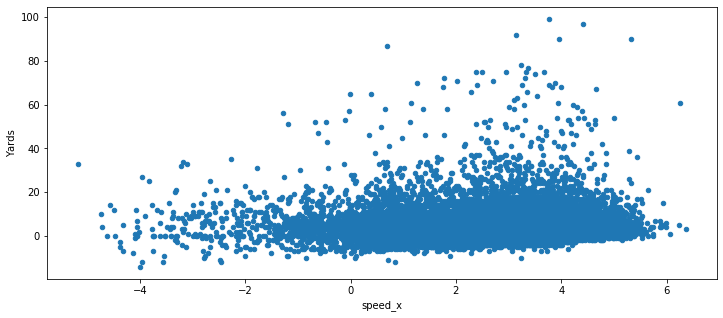

In [652]:
plt.figure(figsize=(12, 5))
plt.scatter(df_play.speed_x, df_play.Yards, s=20)
plt.xlabel("speed_x")
plt.ylabel("Yards")

plt.show()

### Rusher position pc

In [551]:
def get_influence_radius(dist, min_rad=4, max_rad=10, dist_threshold=20):
    if dist <= dist_threshold:
        return min_rad + (max_rad - min_rad) * (dist/dist_threshold)**2
    else:
        return max_rad

In [552]:
def get_player_influence(row, row_rusher, delta_t=1, S_max=10, eps=1e-6):
    ## calc distribution mean
    mean = [row.X_std + delta_t * row.S * np.cos(row.Dir_std)/2, 
            row.Y_std + delta_t * row.S * np.sin(row.Dir_std)/2]
    
    ## calc distribution covariance matrix
    dist_to_rusher = np.sqrt((row.X_std - row_rusher.X_std)**2 + (row.Y_std - row_rusher.Y_std)**2)
    inf_radius = get_influence_radius(dist_to_rusher)
    R = np.array([[np.cos(row.Dir_std), -np.sin(row.Dir_std)], 
                  [np.sin(row.Dir_std), np.cos(row.Dir_std)]])
    S = np.array([[inf_radius * (1 + (row.S/S_max)**2)/2, 0], 
                  [0, inf_radius * (1 - (row.S/S_max)**2)/2]])
    cov = np.dot(np.dot(R, S), np.dot(S, np.linalg.inv(R)))
    
    ## calc and return normed pdf
    denom = norm.pdf([row.X_std, row.Y_std], mean=mean, cov=cov)
    influence = lambda x: norm.pdf(x, mean=mean, cov=cov)/(denom + eps)
    return influence 

In [580]:
def get_pitch_control(df_play, delta_t=1, no_offense=False, no_rusher=False):
    row_rusher = df_play[df_play.IsBallCarrier].iloc[0]
    
    ## get offense influences
    get_inf = lambda row: get_player_influence(row, row_rusher, delta_t=delta_t)
    offense_infs = []
    if no_offense == False:
        offense_infs = list(df_play[(df_play.IsOnOffense) & 
                                    (df_play.IsBallCarrier == False)].apply(get_inf, axis=1).values)
    if no_rusher == False:
        offense_infs.append(get_player_influence(row_rusher, row_rusher, delta_t=delta_t))
            
    defense_infs = df_play[df_play.IsOnOffense == False].apply(get_inf, axis=1).values 
    
    pc = lambda x: sigmoid(sum([inf(x) for inf in offense_infs]) 
                                     - sum([inf(x) for inf in defense_infs]))
    return pc

In [625]:
def get_point_pc(row_rusher, point_type):
    if point_type == 'rusher_pose':
        point = (row_rusher.X_std, row_rusher.Y_std)
    elif point_type == 'ifo_rusher':
        point = (row_rusher.X_std + row_rusher.S * np.cos(row_rusher.Dir_std), 
                 row_rusher.Y_std + row_rusher.S * np.sin(row_rusher.Dir_std))
    else:
        return -1
    return row_rusher.pitch_control(point)

In [582]:
%%time
g = df.groupby('PlayId').apply(lambda df: get_pitch_control(df, no_rusher=True))
df_play['pitch_control'] = df_play.PlayId.map(g)

CPU times: user 7min 35s, sys: 2min 13s, total: 9min 48s
Wall time: 4min 54s


In [626]:
%%time
df_play['ifo_rusher_pc'] = df_play.apply(lambda row: get_point_pc(row, point_type='ifo_rusher'), 
                                          axis=1)

CPU times: user 1min 41s, sys: 624 ms, total: 1min 42s
Wall time: 1min 41s


In [636]:
spearmanr(df_play.Yards, df_play.ifo_rusher_pc)

SpearmanrResult(correlation=0.16184115112872352, pvalue=9.46671300400127e-136)

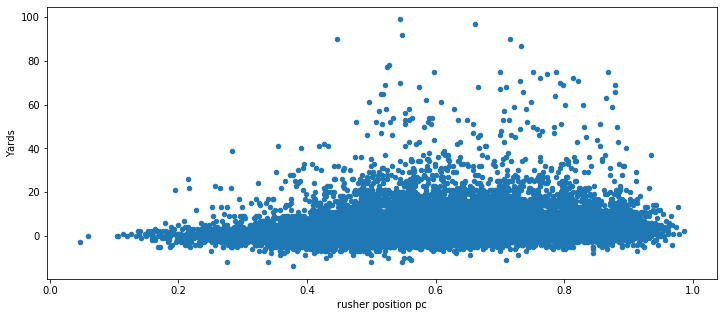

In [637]:
plt.figure(figsize=(12, 5))
plt.scatter(df_play.ifo_rusher_pc, df_play.Yards, s=20)
plt.xlabel("rusher position pc")
plt.ylabel("Yards")

plt.show()

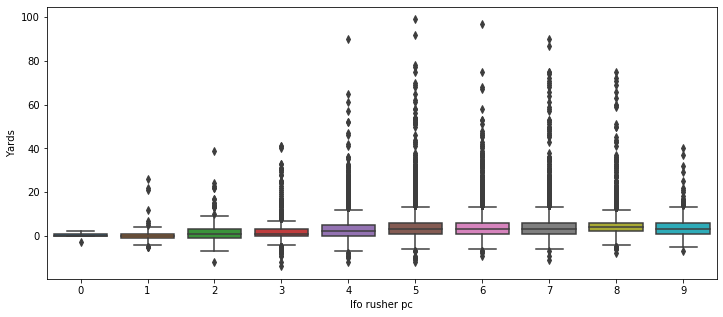

In [639]:
plt.figure(figsize=(12, 5))
df_play['ifo_rusher_pc_binned'] = pd.cut(df_play.ifo_rusher_pc, bins=10, labels=False)
sns.boxplot(x=df_play.ifo_rusher_pc_binned, y=df_play.Yards)
plt.xlabel("Ifo rusher pc")
plt.ylabel("Yards")

plt.show()

In [640]:
df_play.groupby('ifo_rusher_pc_binned').Yards.mean()

ifo_rusher_pc_binned
0    0.363636
1    0.723577
2    1.314856
3    2.076169
4    3.483932
5    4.568128
6    4.424809
7    4.646014
8    4.990941
9    4.257384
Name: Yards, dtype: float64

# Single play analysis

In [524]:
play_ids = df.PlayId.sort_values().unique()
play_ids[:10]

array([20170907000118, 20170907000139, 20170907000189, 20170907000345,
       20170907000395, 20170907000473, 20170907000516, 20170907000653,
       20170907000680, 20170907000801])

In [599]:
play_id = 20170907000801#df[df.Yards == df.Yards.max()].PlayId.values[0]

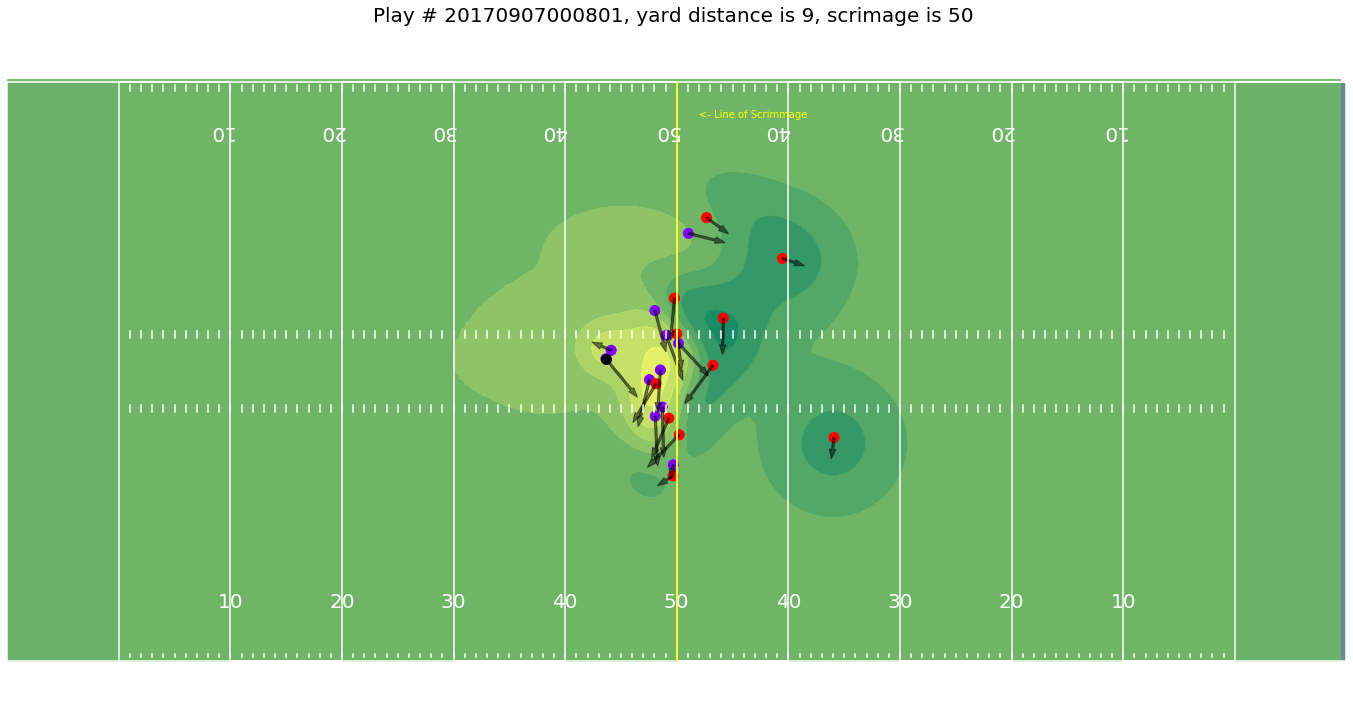

In [600]:
show_pitch_control(play_id, df, no_rusher=True)